# Dingocar Demo 

This Notebook will take allow you to train a Dingocar (_Donkeycar, down-under_). The model will be trained using data uploaded to your Google Drive. The trained model will be saved in your nominated Google Drive Folder .

## Requirements

A zip file of training data. I recomend a zip file because you'll be transfering the data from drive to the virtual machine this notebook is running on and I found this to be orders of magnitude faster if you zip things up first. If you dont have data but you want to have a play I have a public folder  [here](https://drive.google.com/file/d/1gv5k5vK90QOSgenwT42DMm-jmBdB9yEX/view?usp=sharing). Make a folder in your google drive called `dingocar` and add this folder.

Some knowledge of python, and a high level understanding of Machine Learning, not too much, just.

If anyone want an introduction to CNNs.

- [Convolutional Neural Networks (CNNs) explained](https://www.youtube.com/watch?v=YRhxdVk_sIs) Length = 8m:36s
- [A friendly introduction to Convolutional Neural Networks and Image Recognition](https://www.youtube.com/watch?v=2-Ol7ZB0MmU) Length = 32min:07min 

```

Training Time:
--------------

Input data --> ML Magic --> Prediction

                  ^               |
                  |    ERROR      |
               (Prediction - Label)^2   
            

Prediction Time:
----------------

Input data --> ML Magic --> Prediction

```

---

## Setup

First we need to:

- Clone the git repo
- Change to the requied directory
- Install the python modules
- Make a directory on the Google Colab virtual mahine to copy your training data into

In [5]:
# !git clone https://github.com/tall-josh/dingocar.git
# %cd dingocar
# !python setup.py develop
# %mkdir data

## Connect to Google Drive

This piece of code will mount the your google drive to this Google Colab virtual machine. It will prompt you to follow a link to get a verification code. Once you get it, copy and paste it in the box provided and hit enter.

You can nevigate the file system by clicking the "Files" tab in the  <-- left side bar. All your google drive files should be in `/content/drive/My\ Drive`

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

Here we copy the contents of  '`your/data/directory`' to the  '`data`' directory we created earlier.

In [7]:
# # Gotch'a:
# # 1. 'My Drive' has a space so you'll need to delimit it with a '\' or put the 
# #     path in 'single quotes'. ie:
# #     '/content/drive/My Drive' or /content/drive/My\ Drive

# # 2. You can right click on the file system to the right to get the path of the 
# #    file or folder. It ommits the leading '/' before the 'content'. So don't 
# #    forget to add it. ie: 
# #    'content/'  = :-(
# #    '/content/' = :-) 
# !rm -r ./data/*
# !rsync -r --info=progress2 '/content/drive/My Drive/dingocar/data/tub.zip' ./data
# !cd data && unzip tub.zip > _ && cd ..
# !echo "Number of examples: `ls data/tub/*.jpg | wc -l`"

## Import some required modules

In [8]:
%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow
import os
from PIL import Image
from glob import glob
import numpy as np
import json
from tqdm import tqdm

## Load and visualise the data

Donkeycar calls the directory(s) where your training data is stored a "_tub_". The Dingocar follows the same convention.

`Tubs` contain 3 types of files:
- images: in the form of `.jpg`
- records: in the form `.json`
- `meta` which contains some aditional information, also `.json`

Below we set the `tub` location and visualize an image and record

Steering: -0.6476189749581474
Throttle: 0.19523838588169648


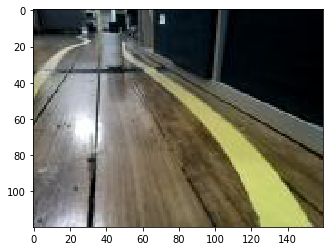

In [9]:
from donkeycar.parts.datastore import Tub
from scripts.make_model_name import extract_if_not_extracted

dingo_archive = '../mycar/data/silverpond_tall-josh_2019-07-30_22:10:56/'
tub_path      = extract_if_not_extracted(dingo_archive)

tub = Tub(tub_path)

# Tubs provide a simple way to access the training.
# Each entry is a dict record which contains the 
# a camera image plus the steering and throttle commands
# that were recorded when driving the car manually.
# The dict keys are as follows.
IMAGE_KEY    = "cam/image_array"
STEERING_KEY = "user/angle"
THROTTLE_KEY = "user/throttle"

# Read a single record from the tub
idx = 123
record = tub.get_record(idx)

print(f"Steering: {record[STEERING_KEY]}")
print(f"Throttle: {record[THROTTLE_KEY]}")
imshow(record[IMAGE_KEY])

## Data Augmentation

Data augmentation allows us to add a bit more variety to the training data. One very handy augmentation transformation is to randomly mirror the input image and the steering label. This ensurse the data contains the same number or left and right turns so the neural network does not become bias to a specifc direction of turn. 

There are also some other augmentation transformations you can apply below. These will hopefully make the network a bit more robust to canging lighting and help prevent overfitting.

loading config file: ../mycar/config.py
loading personal config over-rides

config loaded
(120, 160, 3)
Steering: 1.0
Throttle: 0.2


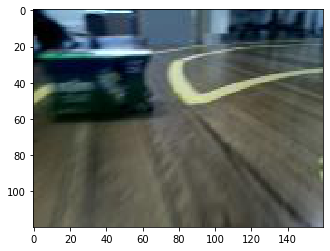

In [10]:
# import config
# from functools import partial
from donkeycar.parts.augment import dingo_aug
import donkeycar as dk
cfg = dk.load_config(config_path="../mycar/config.py")

#DATA AUGMENTATOION
#Control the data augmentation step if --aug is passed to manage.py train
# zeroth element of the tuple is always the probabilty the given augmenation
# operation will be performed. The other elements are variabls specific to the 
# operation itself. 
AUG_MIRROR_STEERING       = (0.5,)
AUG_SALT_AND_PEPPER       = (0.2,  0.1)       # Turn pixel black or white with X probablilty.
AUG_100S_AND_1000S        = (0.2,  0.1)       # Turn pixel random rgb color with X probablilty.
AUG_PIXEL_SATURATION      = (0.2,  10, 60)    # Select a number between X and Y and add it all the pixel values. Clip if above 255 or below 0.
AUG_SHUFFLE_CHANNELS      = (0.2,)             # Shuffle RGB channels
AUG_BLOCKOUT              = (0.2, 0.15, 0.40) # Set a portion of the image to zero. Size of the block is a random fraction of the image size between X and Y
AUG_JITTER_STEERING       = (0.2, -0.1, 0.1)  # Pertabate steering command
AUG_JITTER_THROTTLE       = (0.2,  0.0, 0.1)  # Pertabate throttle command

cfg.AUG_MIRROR_STEERING  = AUG_MIRROR_STEERING
cfg.AUG_SALT_AND_PEPPER  = AUG_SALT_AND_PEPPER
cfg.AUG_100S_AND_1000S   = AUG_100S_AND_1000S
cfg.AUG_PIXEL_SATURATION = AUG_PIXEL_SATURATION
cfg.AUG_SHUFFLE_CHANNELS = AUG_SHUFFLE_CHANNELS
cfg.AUG_BLOCKOUT         = AUG_BLOCKOUT
cfg.AUG_JITTER_STEERING  = AUG_JITTER_STEERING
cfg.AUG_JITTER_THROTTLE  = AUG_JITTER_THROTTLE

def record_transform(record_dict):
    record   = tub.read_record(record_dict)
    
    image    = record[IMAGE_KEY]
    steering = record[STEERING_KEY]
    throttle = record[THROTTLE_KEY]
    image, steering, throttle = dingo_aug(cfg, image, steering, throttle)
    record[IMAGE_KEY]    = image
    record[STEERING_KEY] = steering
    record[THROTTLE_KEY] = throttle
    return record

if tub.df is None:
    tub.update_df()

X_keys = [IMAGE_KEY]
Y_keys = [STEERING_KEY, THROTTLE_KEY]
train_gen = tub.get_train_gen(X_keys, Y_keys, batch_size=1, record_transform=record_transform)
#valid_gen = tub.get_train_gen(X_keys, Y_keys, record_transform=None)
record = next(train_gen)
INPUTS           = 0
IDX_FOR_IMAGE    = 0
OUTPUTS          = 1
IDX_FOR_STEERING = 0
IDX_FOR_THROTTLE = 1
BATCH_IDX        = 0

single_image_array = record[INPUTS][IDX_FOR_IMAGE][BATCH_IDX]
print(single_image_array.shape)
print(f"Steering: {record[OUTPUTS][IDX_FOR_STEERING][BATCH_IDX]}")
print(f"Throttle: {record[OUTPUTS][IDX_FOR_THROTTLE][BATCH_IDX]}")
imshow(single_image_array)

## Define the CNN

In [20]:
from tensorflow.python.keras.layers import Convolution2D
from tensorflow.python.keras.layers import Dropout, Flatten, Dense
from donkeycar.parts.keras import KerasLinear
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model, load_model

# Tub objects maintain a dictionary of data. You can access the data via 'keys'.
# Traditionally x stands for inputs and y stands for outputs.
# In our case, for every input image (x) there are 2 output labels,
# steering angle and throttle (y).
X_KEYS = [IMAGE_KEY]
Y_KEYS = [STEERING_KEY, THROTTLE_KEY]

# If you'd like you can play with this neural network as much as you like. See
# if you can get the network to be more accurate!
# The only things you need to watch out for are:
#   1. 'img_in' cannot change.
#   2. 'angle_out' must always haev 'units=1'
#   3. 'throttle_out' must always have 'units=1'
def convolutional_neural_network():
    img_in = Input(shape=(120, 160, 3), name='img_in')                                                                                                                       
    x = img_in                                                                                                                                                               
    
    # Convolution2D class name is an alias for Conv2D 
    x = Convolution2D(filters=24, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)                                                                                  
    x = Convolution2D(filters=32, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)                                                                                  
    x = Convolution2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)                                                                                  
    x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu')(x)                                                                                  
    x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(x)                                                                                  
    
    x = Flatten(name='flattened')(x)
    x = Dense(units=100, activation='linear')(x)                                                                                                                             
    x = Dropout(rate=.2)(x)
    x = Dense(units=50, activation='linear')(x)                                                                                                                              
    x = Dropout(rate=.2)(x)
    # categorical output of the angle
    angle_out = Dense(units=1, activation='linear', name='angle_out')(x)                                                                                                     
    
    # continous output of throttle
    throttle_out = Dense(units=1, activation='linear', name='throttle_out')(x)                                                                                               
    
    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])                                                                                                        
    
    model.compile(optimizer='adam',
                  loss={'angle_out': 'mean_squared_error',
                        'throttle_out': 'mean_squared_error'},
                  loss_weights={'angle_out': 0.5, 'throttle_out': 0.5})                                                                                                       
    
    return model

# KerasLinear is a class the contains some functions we can use to train
# our model and to get predictions out if it later.
kl = KerasLinear(model=convolutional_neural_network())

## Train the model


In [ ]:
#from manage import train
#import config

# Load 16 image at a time into the model
BATCH_SIZE       = 32

# 80% of the data is used for training. 20% for validation
TRAIN_FRAC = 0.8

# Number of time to look over all the training data
EPOCHS = 100

# Stop training if the validation loss has not improved for the last 'PATIENTS'
# Epochs.
USE_EARLY_STOP = True 
PATIENCE = 5


# Where to save the trained model
new_model_path = "my_notebook_model.h5"

# If you want to start from a pre-trained model you can add the path here
base_model_path   = None

train_steps = int(tub.get_num_records() * 0.8) // BATCH_SIZE
valid_steps = int(tub.get_num_records() * (1 - 0.8)) // BATCH_SIZE
print(train_steps)

# These are generators that will be used to feed data into the model
# when training. The generator uses a constant random seed so the train/val
# split is the same every time.
train_gen, valid_gen = tub.get_train_val_gen(X_keys, Y_keys,
                                             batch_size=BATCH_SIZE,
                                             record_transform=record_transform,
                                             valid_transform=None,
                                             train_frac=TRAIN_FRAC)

history = kl.model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=EPOCHS,
                              verbose=cfg.VEBOSE_TRAIN,
                              validation_data=valid_gen,
                              callbacks=[],
                              validation_steps=valid_steps,
                              workers=1,
                              use_multiprocessing=False)

521
Epoch 1/100
521/521 [==============================] - 261s 501ms/step - loss: 0.3778 - angle_out_loss: 0.3581 - throttle_out_loss: 0.0196 - val_loss: 0.3117 - val_angle_out_loss: 0.3002 - val_throttle_out_loss: 0.0116
Epoch 2/100
521/521 [==============================] - 262s 503ms/step - loss: 0.3319 - angle_out_loss: 0.3201 - throttle_out_loss: 0.0118 - val_loss: 0.3032 - val_angle_out_loss: 0.2970 - val_throttle_out_loss: 0.0062
Epoch 3/100
521/521 [==============================] - 260s 498ms/step - loss: 0.3032 - angle_out_loss: 0.2949 - throttle_out_loss: 0.0084 - val_loss: 0.2909 - val_angle_out_loss: 0.2835 - val_throttle_out_loss: 0.0075
Epoch 4/100
521/521 [==============================] - 260s 499ms/step - loss: 0.2917 - angle_out_loss: 0.2836 - throttle_out_loss: 0.0080 - val_loss: 0.2889 - val_angle_out_loss: 0.2840 - val_throttle_out_loss: 0.0049
Epoch 5/100
190/521 [=========>....................] - ETA: 2:26 - loss: 0.2876 - angle_out_loss: 0.2805 - throttle_out_

# Visualize Predictions

In [ ]:
from dingocar.parts.keras import KerasLinear

new_model_path = "/content/drive/My Drive/dingocar/no_mirror1.hdf5"
trained_model = new_model_path

# Load a pre-trained model
model = KerasLinear()
model.load(trained_model)


In [ ]:
from dingocar.parts.datastore import Tub

_, val_gen = tub.get_train_val_gen(X_KEYS, Y_KEYS,
                      batch_size=1,
                      train_frac=TRAIN_TEST_SPLIT,
                      train_record_transform=None,
                      val_record_transform=None)

In [ ]:
preds = []
truth = []

val_count = int(tub.get_num_records() * (1-TRAIN_TEST_SPLIT))
for _ in tqdm(range(val_count)):
    sample = next(val_gen)
    pred = model.run(sample[0][0][0])
    preds.append(pred)
    truth.append((sample[1][0][0], sample[1][1][0]))
        
preds = np.array(preds)
truth = np.array(truth)
print(preds.shape)
print(truth.shape)


In [ ]:
import matplotlib.pyplot as plt

def mean_squared_error(preds, true):
  squared_error = (true - preds)**2
  return np.mean(squared_error)

def xy_scatter(preds, truth):
    fig = plt.figure(figsize=(14,14))
    steering_p = preds[...,0]
    throttle_p = preds[...,1]
    steering_t = truth[...,0]
    throttle_t = truth[...,1]
    
    steering_mse = mean_squared_error(steering_p, steering_t)
    throttle_mse = mean_squared_error(throttle_p, throttle_t)
    plt.plot(steering_p, steering_t, 'b.')
    plt.title(f"MSE: {steering_mse:.3f}")
    plt.xlabel("predictions")
    plt.ylabel("ground truth")
    plt.gca().set_xlim(-1, 1)
    plt.show()
#     fig = plt.gcf()
#     fig.savefig(path + "/pred_vs_anno.png", dpi=100)

# Only display the validation set
xy_scatter(preds, truth)

In [ ]:
preds = []
truth = []

for idx in tqdm(range(tub.get_num_records())):
    sample = tub.get_record(idx)
    pred = model.run(sample[IMAGE_KEY])
    preds.append(pred)
    truth.append((sample[STEERING_KEY], sample[THROTTLE_KEY]))
        
preds = np.array(preds)
truth = np.array(truth)
print(preds.shape) 


In [ ]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [ ]:

def plt_image(ax, image, title):
  ax.imshow(image)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)

def plt_samples(idxs, axs, tub):
  records = [tub.get_record(i) for i in idxs]
  images = [r[IMAGE_KEY] for r in records]
  titles = [f"frame: {i}" for i in idxs]
  for a,i,t in zip(axs, images, titles):
    plt_image(a,i,t)
        
def time_series(x=300):#, axs=axs, tub=tub):
  
    fig = plt.figure(figsize=(21,12))
    plt.tight_layout()

    ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=5)
    ax2 = plt.subplot2grid((2, 5), (1, 0))
    ax3 = plt.subplot2grid((2, 5), (1, 1))
    ax4 = plt.subplot2grid((2, 5), (1, 2))
    ax5 = plt.subplot2grid((2, 5), (1, 3))
    ax6 = plt.subplot2grid((2, 5), (1, 4))
    axs = [ax2, ax3, ax4, ax5, ax6]
    steering_p = preds[...,0]
    throttle_p = preds[...,1]
    steering_t = truth[...,0]
    throttle_t = truth[...,1]
  
    idxs = np.arange(x-2,x+3)
    plt_samples(idxs, axs, tub)
  
    start = x-300
    end  = x + 300
    ax1.plot(steering_p, label="predictions")
    ax1.plot(steering_t, label="ground truth")
    #ax1.axvline(x=x, linewidth=4, color='r')
    ax1.legend(bbox_to_anchor=(0.91, 0.96), loc=2, borderaxespad=0.)
    ax1.set_title("Time Series Throttle Predictions vs Ground Truth")
    ax1.set_xlabel("time (frames)")
    ax1.set_ylabel("steering command")
    ax1.set_xlim(start, end)
    
#time_series(x=600)
interact(time_series, x=(300, len(truth-300)))#, axs=fixed(axs), tub=fixed(tub))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt    
testData = np.array([[0,0], [0.1, 0], [0, 0.3], [-0.4, 0], [0, -0.5]])
fig, ax = plt.subplots()
sctPlot, = ax.plot(testData[:,0], testData[:,1], "o", picker = 5)
plt.grid(True)
plt.axis([-0.5, 0.5, -0.5, 0.5])

def on_pick(event):
    artist = event.artist
    artist.set_color(np.random.random(3))
    print("click!")
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)